In [1]:
import os, sys
sys.path.append('/home/vagrant/project')
sys.path.append('/vagrant')
os.environ['PROJ_LIB'] = '/home/vagrant/Miniconda3-4.6.14-Linux-x86_64/envs/py3openwind/share/proj'
os.environ['DJANGO_SETTINGS_MODULE'] = 'project.settings'

In [2]:
import django
django.setup()

from django.conf import settings

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from nansat.nansat import Nansat
from nansat.domain import Domain
from nansat.tools import haversine
from openwind import sar_wind
from geospaas_wind.utils import wind_from_sar_and_arome_forecast

In [4]:
%matplotlib inline
import cartopy.feature as cfeature
from cartopy import config
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

In [44]:
fn = 'http://nbstds.met.no/thredds/dodsC/NBS/S1B/2019/08/21/IW/S1B_IW_GRDM_1SDV_20190821T155906_20190821T155939_017686_021461_7D4D.nc'

In [28]:
n = Nansat(fn)

/home/vagrant/Miniconda3-4.6.14-Linux-x86_64/envs/py3openwind/lib/python3.6/site-packages/nansat/mappers/opendap.py:112: UserWarning: Time consuming loading time from OpenDAP...
  warnings.warn('Time consuming loading time from OpenDAP...')
/home/vagrant/Miniconda3-4.6.14-Linux-x86_64/envs/py3openwind/lib/python3.6/site-packages/nansat/mappers/opendap.py:114: UserWarning: Loading time - OK!
  warnings.warn('Loading time - OK!')


In [29]:
n.resize(pixelsize=1000)

0.04006915663203421

In [30]:
s0 = 10.*np.log10(n['sigma0_VV'])

In [31]:
lon, lat = n.get_geolocation_grids()

In [32]:
s0[np.isinf(s0)] = np.nan

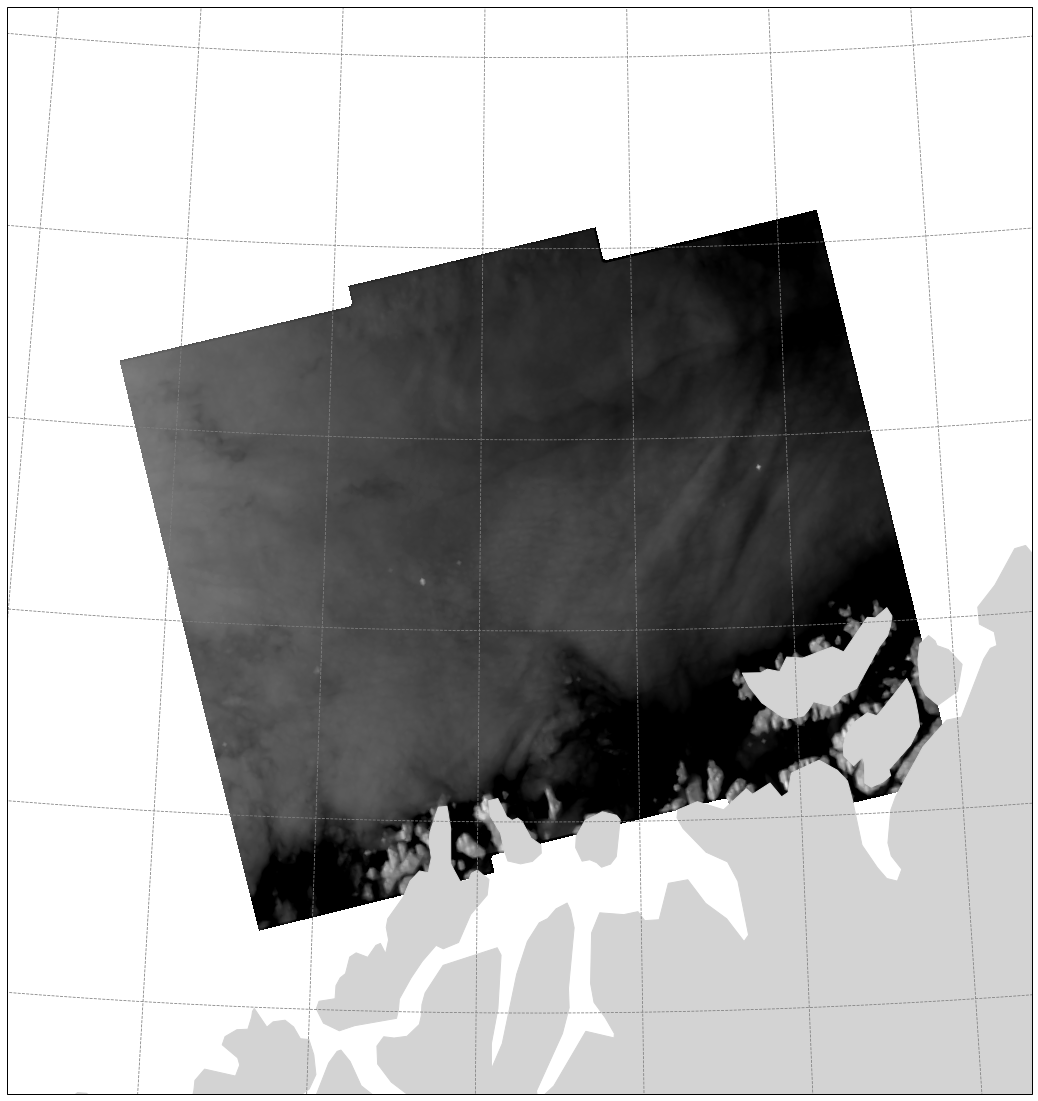

In [34]:
globe = ccrs.Globe(ellipse='WGS84', semimajor_axis=6378137, flattening=1/298.2572235604902)
proj = ccrs.Stereographic(central_longitude=np.mean(lon), central_latitude=np.mean(lat), globe=globe)

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': proj}, figsize=(20, 20))
extent = [np.min(lon)-.5, np.max(lon)+.5, np.min(lat)-.5, np.max(lat)+.5]
land_f = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray')

axs.set_extent(extent, crs=ccrs.PlateCarree())
axs.gridlines(color='gray', linestyle='--')
axs.add_feature(land_f)
#axs.coastlines(resolution='10m')
axs.contourf(lon, lat, s0, 400, vmin=-20, vmax=0, transform=ccrs.PlateCarree(), cmap='gray')
#axs.set_title('NRCS', y=1.05, fontsize=20)

In [59]:
fn = '/vagrant/S1B_IW_GRDM_1SDV_20190821T155906_20190821T155939_017686_021461_7D4D.nc'
n = Nansat(fn)
n.resize(pixelsize=1000)
s0 = 10.*np.log10(n['sigma0_VV'])
s0[np.isinf(s0)] = np.nan
lon, lat = n.get_geolocation_grids()

=>Sentinel-1 GRD data<=


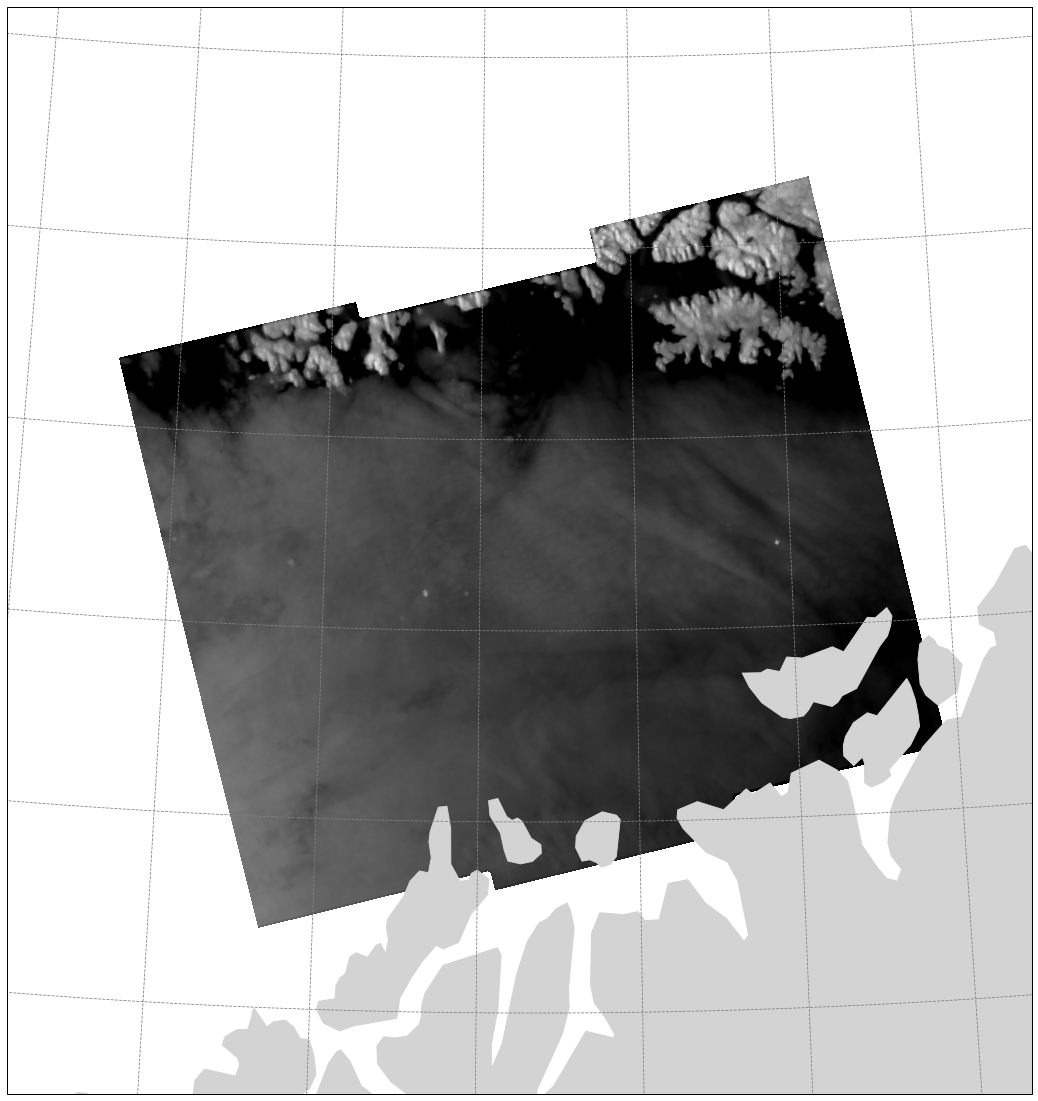

In [60]:
globe = ccrs.Globe(ellipse='WGS84', semimajor_axis=6378137, flattening=1/298.2572235604902)
proj = ccrs.Stereographic(central_longitude=np.mean(lon), central_latitude=np.mean(lat), globe=globe)

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': proj}, figsize=(20, 20))
extent = [np.min(lon)-.5, np.max(lon)+.5, np.min(lat)-.5, np.max(lat)+.5]
land_f = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray')

axs.set_extent(extent, crs=ccrs.PlateCarree())
axs.gridlines(color='gray', linestyle='--')
axs.add_feature(land_f)
#axs.coastlines(resolution='10m')
axs.contourf(lon, lat, s0, 400, vmin=-20, vmax=0, transform=ccrs.PlateCarree(), cmap='gray')
#axs.set_title('NRCS', y=1.05, fontsize=20)

In [ ]:
# Compare GCP_* in the opendap-stream and in the nc-file

In [50]:
from netCDF4 import Dataset
ds = Dataset(fn)
ds.variables.keys()

odict_keys(['time', 'lat', 'lon', 'Amplitude_VH', 'Amplitude_VV', 'crsWGS84', 'dn_VV', 'sigmaNought_VV', 'gamma_VV', 'betaNought_VV', 'gamma_VH', 'betaNought_VH', 'dn_VH', 'sigmaNought_VH', 'noiseCorrectionMatrix_VV', 'noiseCorrectionMatrix_VH', 'swathList', 'GCP_longitude_VV', 'GCP_line_VH', 'GCP_line_VV', 'GCP_pixel_VV', 'GCP_elevationAngle_VV', 'GCP_incidenceAngle_VV', 'GCP_latitude_VV', 'GCP_height_VH', 'GCP_height_VV', 'GCP_latitude_VH', 'GCP_azimuthTime_VV', 'GCP_elevationAngle_VH', 'GCP_pixel_VH', 'GCP_slantRangeTime_VH', 'GCP_azimuthTime_VH', 'GCP_longitude_VH', 'GCP_slantRangeTime_VV', 'GCP_incidenceAngle_VH', 's1Level1ProductSchema_VH', 's1Level1ProductSchema_VV', 'orbitList_VH', 'swathMergeList_VH', 'coordinateConversionList_VH', 'orbitList_VV', 'swathMergeList_VV', 'coordinateConversionList_VV'])

In [46]:
ampVV = ds.variables['Amplitude_VV'][:].data[0,::10,::10]
lon = ds.variables['lon'][:].data[::10,::10]
lat = ds.variables['lat'][:].data[::10,::10]

In [53]:
#pixel = ds['GCP_pixel_VV'][:].data
#line = ds['GCP_line_VV'][:].data
#lon = ds['GCP_longitude_VV'][:].data
#lat = ds['GCP_latitude_VV'][:].data

In [57]:
ampVV.shape, lon.shape, lat.shape

((540, 628), (12, 21), (12, 21))

In [56]:
#lon = lon.reshape(np.unique(line[:].data).shape[0], np.unique(pixel[:].data).shape[0])
#lat = lat.reshape(np.unique(line[:].data).shape[0], np.unique(pixel[:].data).shape[0])

In [58]:
lon

array([[ 17.55899239,  17.87236977,  18.18666077,  18.50185013,
         18.81792641,  19.13487434,  19.4526825 ,  19.77133751,
         20.09082413,  20.41113091,  20.73223877,  21.05413628,
         21.37680817,  21.70023727,  22.02441216,  22.34931183,
         22.67492485,  23.00123215,  23.32821846,  23.65586662,
         23.98206711],
       [ 17.40944481,  17.72528076,  18.04205132,  18.35974121,
         18.678339  ,  18.99783134,  19.31820297,  19.63944244,
         19.9615345 ,  20.28446388,  20.60821533,  20.9327755 ,
         21.25812912,  21.58425903,  21.91114998,  22.23878479,
         22.56715012,  22.89622498,  23.22599602,  23.55644417,
         23.88544273],
       [ 17.2590313 ,  17.57736778,  17.89665794,  18.21689224,
         18.53805542,  18.86013603,  19.18311691,  19.50698662,
         19.83172798,  20.15732765,  20.48377037,  20.81104088,
         21.13912392,  21.46800232,  21.79765892,  22.12808037,
         22.45924568,  22.79114151,  23.12374878,  23.4570

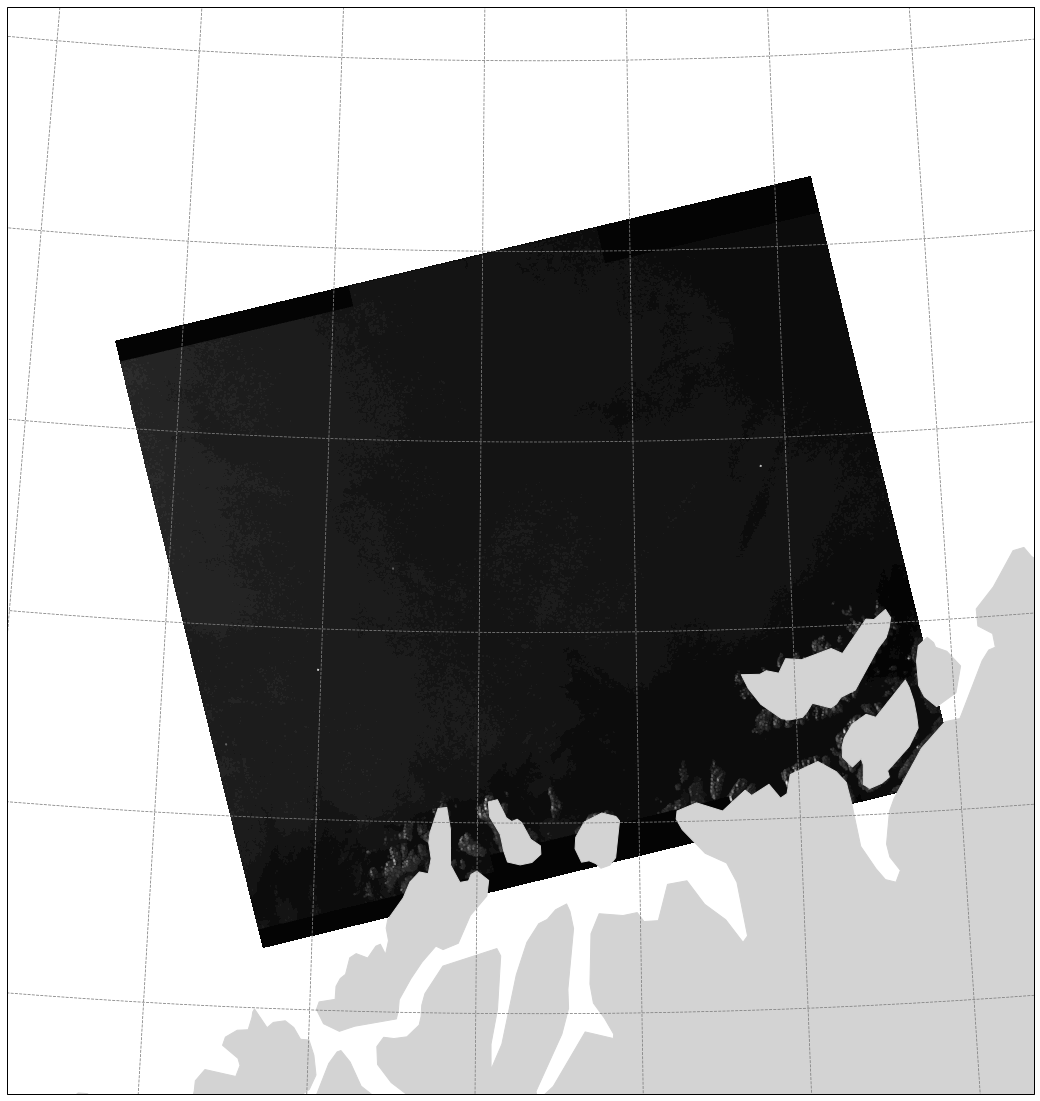

In [22]:
globe = ccrs.Globe(ellipse='WGS84', semimajor_axis=6378137, flattening=1/298.2572235604902)
proj = ccrs.Stereographic(central_longitude=np.mean(lon), central_latitude=np.mean(lat), globe=globe)

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': proj}, figsize=(20, 20))
extent = [np.min(lon)-.5, np.max(lon)+.5, np.min(lat)-.5, np.max(lat)+.5]
land_f = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray')

axs.set_extent(extent, crs=ccrs.PlateCarree())
axs.gridlines(color='gray', linestyle='--')
axs.add_feature(land_f)
#axs.coastlines(resolution='10m')
axs.contourf(lon, lat, ampVV, 40, transform=ccrs.PlateCarree(), cmap='gray')
#axs.set_title('NRCS', y=1.05, fontsize=20)

In [35]:
n.mapper

'opendap_sentinel1'

In [31]:
fn = '/home/vagrant/project/products/WIND_S1A_IW_GRDM_1SDV_20190709T165618_20190709T165650_028043_032AC4_6010.nc'
w = Nansat(fn)

=>Near surface wind from Sentinel-1 GRD data<=


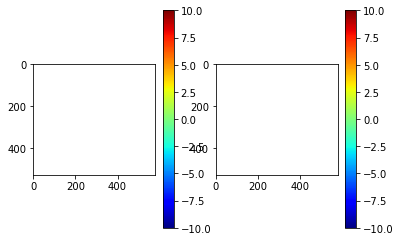

In [35]:
plt.subplot(1,2,1)
plt.imshow(w['U'], vmin=-10, vmax=10, cmap='jet')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(w['V'], vmin=-10, vmax=10, cmap='jet')
plt.colorbar()
plt.show()

In [38]:
w

----------------------------------------
/home/vagrant/project/products/WIND_S1A_IW_GRDM_1SDV_20190709T165618_20190709T165650_028043_032AC4_6010.nc----------------------------------------
Mapper: netcdf_cfBand : 1 model_windspeed
  colormap: jet
  dataType: 7
  grid_mapping: stereographic
  long_name: Wind speed
  minmax: 0 18
  name: model_windspeed
  NETCDF_DIM_time: 43653.70576388889
  NETCDF_VARNAME: model_windspeed
  short_name: W
  SourceBand: 1
  SourceFilename: NETCDF:"/home/vagrant/project/products/WIND_S1A_IW_GRDM_1SDV_20190709T165618_20190709T165650_028043_032AC4_6010.nc":model_windspeed
  standard_name: wind_speed
  time_iso_8601: 2019-07-09T16:56:18.000000
  units: m s-1
  wkv: wind_speed
  _FillValue: 9.969209968386869e+36
Band : 2 U
  colormap: jet
  dataType: 7
  grid_mapping: stereographic
  long_name: Eastward wind velocity
  minmax: -10 10
  name: U
  NETCDF_DIM_time: 43653.70576388889
  NETCDF_VARNAME: U
  short_name: U
  SourceBand: 1
  SourceFilename: NETCDF:"/hom

In [6]:
lon, lat = n.get_geolocation_grids()

In [7]:
srs = '+proj=stere +datum=WGS84 +ellps=WGS84 +lat_0=%.2f +lon_0=%.2f +no_defs'%(np.mean(lat),np.mean(lon))

In [8]:
xmin, xmax, ymin, ymax = -haversine(np.mean(lon),np.mean(lat),np.min(lon),np.mean(lat)), \
                    haversine(np.mean(lon),np.mean(lat),np.max(lon),np.mean(lat)), \
                    -haversine(np.mean(lon),np.mean(lat),np.mean(lon),np.min(lat)), \
                    haversine(np.mean(lon),np.mean(lat),np.mean(lon),np.max(lat))

In [9]:
ext = '-te %.2f %2.f %.2f %.2f -tr 500 500' %(xmin, ymin, xmax, ymax)
#ext = '-lle %.2f %2.f %.2f %.2f -tr 0.02 0.02' %(np.min(lon), np.min(lat), np.max(lon), np.max(lat))

In [10]:
d = Domain(srs, ext)

In [11]:
np.min(lon), np.max(lat)

(4.4050168488147712, 68.443189596061046)

In [12]:
#n.reproject(d)

In [13]:
s0 = n['sigma0_VV']
from shapely.geometry.polygon import Polygon
#lonv, latv = d.get_corners()
#corners = list(zip(lonv,latv))
#corners = n.transform_points(lonv, latv, 1)
#corners

NameError: name 'd' is not defined

In [14]:
n['U']

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

ValueError: 'bboxes' cannot be empty

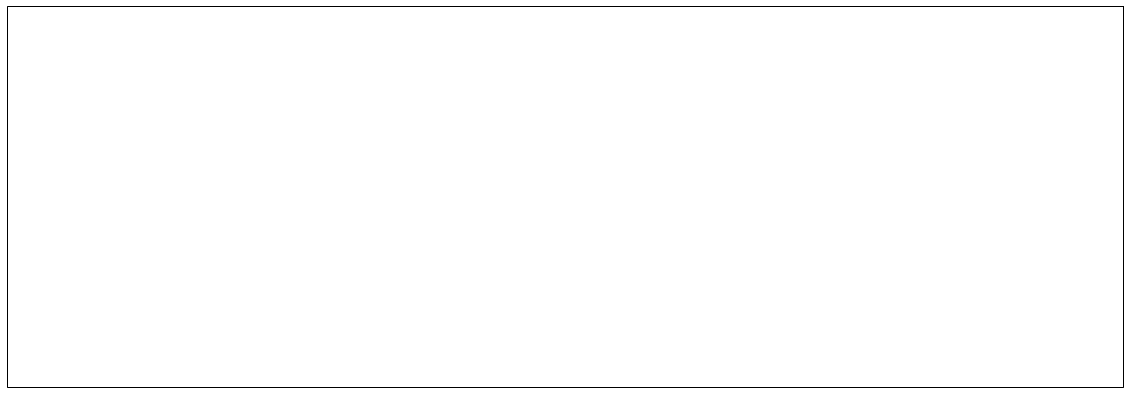

In [13]:
%matplotlib inline
import cartopy.feature as cfeature
from cartopy import config
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

globe = ccrs.Globe(ellipse='WGS84', semimajor_axis=6378137, flattening=1/298.2572235604902)
proj = ccrs.Stereographic(central_longitude=np.mean(lon), central_latitude=np.mean(lat), globe=globe)

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': proj}, figsize=(20, 14))
cm = LinearSegmentedColormap.from_list('windspeed', ['#007af6', 'w', '#f04100' ], N=40)
#extent = [xmin, xmax, ymin, ymax]
extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]
speed_lim = [-20, 0]
land_f = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray')

axs.set_extent(extent, crs=proj)
#im = axs.imshow(10.*np.log10(s0[::-1,::-1]), extent=extent, transform=proj, cmap='gray', clim=speed_lim, interpolation=None)
#im = axs.imshow(amp[::-1,::-1], extent=extent, transform=PlateCarree(), clim=[0,300],cmap='gray', interpolation=None)
axs.contourf(lon, lat, n['U'], 40, vmin=-10, vmax=10, transform=proj, cmap='jet')
#axs.add_feature(pp, crs=proj, facecolor='red', edgecolor='k')
#axs.plot([np.min(lon), np.max(lon)], [np.min(lat), np.max(lat)],
#         color='blue', linewidth=2,
#         # transform=ccrs.Geodetic(),
#         transform=ccrs.PlateCarree(),
#         )
#axs.gridlines(color='gray', linestyle='--')
axs.add_feature(land_f)
axs.coastlines(resolution='50m')
axs.set_title('NRCS', y=1.05, fontsize=20)

#cb = fig.colorbar(im) #, ax=axs.ravel().tolist())

In [69]:
corners[0]

array([ 590.65088825,  460.93278423,   17.42497463, -110.4601991 ])

In [92]:
[np.min(lon), np.max(lon)], [np.min(lat), np.max(lat)]

([18.485705489012389, 26.615552082463516],
 [69.756390023069457, 72.181015870571031])

In [16]:
from shapely.geometry.polygon import Polygon

In [20]:
Polygon?

In [25]:
axs.add_geometries?

In [44]:
axs.plot?

In [52]:
d.transform_points?

In [49]:
d.transform_points(lonv,latv,1)

(array([  2.27373675e-13,  -5.11590770e-13,   5.88000000e+02,
          5.88000000e+02]),
 array([ -2.10320650e-12,   5.38000000e+02,  -6.25277607e-13,
          5.38000000e+02]))

In [101]:
n

----------------------------------------
http://nbstds.met.no/thredds/dodsC/NBS/S1B/2019/06/30/IW/S1B_IW_GRDM_1SDV_20190630T051108_20190630T051141_016921_01FD7F_21CF.nc----------------------------------------
Mapper: opendap_sentinel1Band : 1 lat
  dataType: 6
  long_name: latitude
  name: lat
  SourceBand: 1
  SourceFilename: /vsimem/MS8UDEV6S4.vrt
  standard_name: latitude
  units: degrees_north
  _ChunkSizes: [ 902 1047]
Band : 2 lon
  dataType: 6
  long_name: longitude
  name: lon
  SourceBand: 2
  SourceFilename: /vsimem/MS8UDEV6S4.vrt
  standard_name: longitude
  units: degrees_east
  _ChunkSizes: [ 902 1047]
Band : 3 Amplitude_VH
  coordinates: lat lon
  dataType: 6
  grid_mapping: crsWGS84
  long_name: Amplitude VH-polarisation
  name: Amplitude_VH
  polarisation: VH
  SourceBand: 3
  SourceFilename: /vsimem/MS8UDEV6S4.vrt
  standard_name: surface_backwards_scattering_coefficient_of_radar_wave
  units: 1
  _ChunkSizes: [ 1 1803 2094]
  _FillValue: 0
  _Unsigned: true
Band : 4 A

In [17]:
from netCDF4 import Dataset
ds = Dataset(fn+'#fillmismatch')

In [18]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    title: Sentinel-1 GRD data
    netcdf4_version_id: 4.4.0
    file_creation_date: 2019-06-30T05:30:31Z
    PRODUCT_TYPE: GRD
    ACQUISITION_STOP_TIME: 2019-06-30T05:11:41.006912
    ORBIT_NUMBER: 16921
    BEAM_MODE: IW
    SWATH: IW
    ProductTimelinessCategory: NRT-3h
    keywords: [Earth Science, Spectral/Engineering, RADAR, RADAR backscatter], [Earth Science, Spectral/Engineering, RADAR, RADAR imagery], [Earth Science, Spectral/Engineering, Microwave, Microwave Imagery]
    summary: Sentinel-1 C-band SAR GRD product.
    FACILITY_IDENTIFIER: KSAT
    polarisation: VVVH
    SENSOR_IDENTIFIER: SAR
    MODE: IW
    PIXEL_SPACING: 4.000000e+01
    BEAM_SWATH: IW
    SATELLITE_IDENTIFIER: SENTINEL-1
    keywords_vocabulary: GCMD Science Keywords
    ACQUISITION_START_TIME: 2019-06-30T05:11:08.504857
    institution: Norwegian Meteorological Institute
    ORBIT_DIRECTION: DESCENDING
    LIN

In [19]:
ds.variables['crsWGS84']

<class 'netCDF4._netCDF4.Variable'>
int32 crsWGS84()
    grid_mapping_name: latitude_longitude
    semi_major_axis: 6378137
    inverse_flattening: 298.2572235604902
unlimited dimensions: 
current shape = ()
filling off

In [20]:
ccrs.Globe?

In [21]:
amp = ds.variables['Amplitude_VV'][:].data[0,:,:]
lon = ds.variables['lon'][:].data
lat = ds.variables['lat'][:].data

In [114]:
amp.shape

(5409, 6280)

In [116]:
amp

array([[ 63,  66,  72, ...,   0,   0,   0],
       [ 82,  82,  87, ...,   0,   0,   0],
       [107, 108, 108, ...,   0,   0,   0],
       ..., 
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

In [121]:
plt.contourf?

In [28]:
import folium
geoloc = d.get_border_geojson()
geoloc_n = n.get_border_geojson()
f = folium.Map()
folium.GeoJson(geoloc).add_to(f)
folium.GeoJson(geoloc_n).add_to(f)
f

In [29]:
d.get_pixelsize_meters()

(497.98844762018444, 497.63173124303796)

In [30]:
n.get_pixelsize_meters()

(503.06798246869022, 496.92885522533169)

In [32]:
n[1]

array([[ 71.63549805,  71.63683319,  71.63816833, ...,  72.17719269,
         72.17802429,  72.17884827],
       [ 71.63115692,  71.63248444,  71.63381958, ...,  72.17276001,
         72.17358398,  72.17441559],
       [ 71.62680817,  71.62813568,  71.62947083, ...,  72.1683197 ,
         72.16915131,  72.16997528],
       ..., 
       [ 69.76225281,  69.76348877,  69.76472473, ...,  70.26823425,
         70.26902008,  70.26979828],
       [ 69.75784302,  69.75907898,  69.76031494, ...,  70.26376343,
         70.26454163,  70.26532745],
       [ 69.7534256 ,  69.75466156,  69.75589752, ...,  70.25928497,
         70.2600708 ,  70.260849  ]], dtype=float32)

In [33]:
n.reproject(d)

In [ ]:
n[1]